# Individual Differences: Political Orientation and Moral Foundations 

In [1]:
%matplotlib inline

import os
from joblib import Parallel, delayed
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf

import pickle

from rsa_utils import get_beh_sim, conditions, all_conditions, item_order, tick_labels, vig_cmap

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


***

# Behavior: Political Orientation and Moral Foundations 

In [2]:
import getpass
import os
user = getpass.getuser()
print('Running code as: ', user)

exp_dir = '/home/{}/spm/bids/'.format(user)

Running code as:  fhopp


In [3]:
# Load Survey Data
survey = pd.read_csv(os.path.join(exp_dir, 'participants.tsv'), sep='\t')

use_cols = ['care', 'fairness','loyalty', 'authority', 'sanctity', 
           'pol_af', 'pol_orient', 'age', 'gender', 'participant_id']
survey = survey[use_cols]

# Add string for affiliation
pal_map = {1:'Democrat',2:'Republican',3:'Independent',4:'Unsure'}
survey['pol_af'] = survey['pol_af'].map(pal_map)

In [4]:
survey_long = survey[['pol_orient','pol_af']].melt(id_vars=['pol_af'], value_name='Political Orientation')
survey_long = survey_long.rename(columns={'pol_af':'Political Affiliation'})

In [5]:
ptx_cmap = sns.color_palette('bright', 8)
ptx_cmap = [ptx_cmap[0], ptx_cmap[3], ptx_cmap[4], ptx_cmap[7]]

## Political Orientation X Political Affilation

In [6]:
survey['pol_af'].value_counts()

Republican     23
Democrat       18
Independent    17
Unsure          6
Name: pol_af, dtype: int64

In [7]:
print('Median value for political orientation is:', survey['pol_orient'].median())

Median value for political orientation is: 41.0


In [8]:
plt.style.use("seaborn-poster")

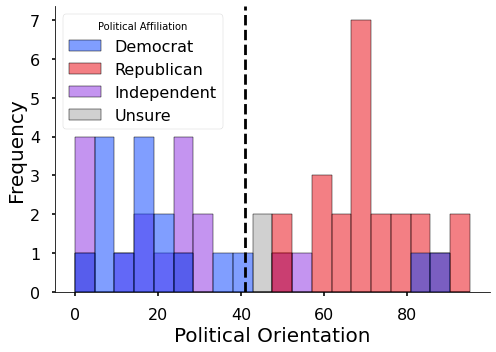

In [9]:
f, ax = plt.subplots(figsize=(7, 5))
sns.histplot(x='Political Orientation', hue='Political Affiliation', bins=20,ax=ax,
             data=survey_long, hue_order=pal_map.values(), palette=ptx_cmap)
sns.despine()
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Political Orientation', fontsize=20)
ax.axvline(survey['pol_orient'].median(), color='black', linestyle='--');
plt.tight_layout()
plt.savefig('new_plots/sample_dist.png', dpi=200, bbox_inches='tight')
plt.show()

## Political Affiliation X Moral Foundations Questionnaire

In [10]:
mfq_polx = survey[['pol_orient','care', 'fairness','loyalty', 'authority', 'sanctity']].melt(id_vars='pol_orient')

mfq_cmap = sns.color_palette("bright", 8)
mfq_cmap = [mfq_cmap[0], mfq_cmap[2], mfq_cmap[4], mfq_cmap[5], mfq_cmap[6]]
mfq_polx['variable'] = mfq_polx['variable'].str.capitalize()

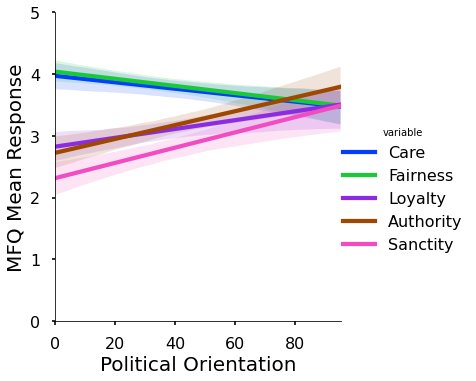

In [11]:
sns.lmplot(x='pol_orient', y='value', hue='variable', data=mfq_polx, aspect=1, scatter=False, palette=mfq_cmap)
plt.ylim(0, 5)
sns.despine()
plt.ylabel('MFQ Mean Response', fontsize=20)
plt.xlabel('Political Orientation', fontsize=20)
plt.savefig('new_plots/polx_mfq.png', dpi=200, bbox_inches='tight')
plt.show()

In [12]:
care_model = smf.ols(formula='care ~ pol_orient + age + gender', data=survey).fit()
fair_model = smf.ols(formula='fairness ~ pol_orient + age + gender', data=survey).fit()
loy_model = smf.ols(formula='loyalty ~ pol_orient + age + gender', data=survey).fit()
auth_model = smf.ols(formula='authority ~ pol_orient + age + gender', data=survey).fit()
sanc_model = smf.ols(formula='sanctity ~ pol_orient + age + gender', data=survey).fit()

In [13]:
print(care_model.summary2())
print(fair_model.summary2())
print(loy_model.summary2())
print(auth_model.summary2())
print(sanc_model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.186   
Dependent Variable: care             AIC:                96.6112 
Date:               2022-08-25 09:49 BIC:                105.0547
No. Observations:   61               Log-Likelihood:     -44.306 
Df Model:           3                F-statistic:        5.569   
Df Residuals:       57               Prob (F-statistic): 0.00202 
R-squared:          0.227            Scale:              0.26783 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       2.7973    0.7831   3.5723  0.0007   1.2293  4.3654
pol_orient     -0.0046    0.0025  -1.8855  0.0645  -0.0095  0.0003
age             0.0218    0.0323   0.6770  0.5011  -0.0428  0.0864
gender          0.4629    0.1361   3.4021  0.0012   0.1904  0.7353
--------------------

## Political Affilation X Moral Foundation Vignettes

In [14]:
vig_beh_files = glob.glob(os.path.join(exp_dir, 'sub-*/beh/sub-*_task-vignette_*_beh.tsv'))
vig_beh_dfs = []
for file in vig_beh_files:
    df = pd.read_csv(file, sep='\t')
    df['run'] = int(file.split('/')[-1].split('-')[-1].split('_')[0])
    vig_beh_dfs.append(df)
vig_beh = pd.concat(vig_beh_dfs)
vig_beh['item'] = vig_beh['stim_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
vig_beh = vig_beh.reset_index()[['sub_id','item','trial_type','run','moral_decision','RT']].sort_values("sub_id")

cond_medians = vig_beh.groupby('trial_type')['moral_decision'].median()
for cond, median in cond_medians.iteritems():
    mask = vig_beh[vig_beh['trial_type']==cond].index
    vig_beh.loc[mask, 'moral_decision'] = vig_beh.loc[mask, 'moral_decision'].fillna(median)

In [15]:
survey = survey.rename(columns={'participant_id':'sub_id'})

In [16]:
# survey = survey.rename(columns={'participant_id':'sub_id'})
vig_beh = survey.merge(vig_beh)
vig_beh = vig_beh.rename(columns={'pol_af':'Political Affiliation'})
mfv_map = {'carep': 'Physical Care', 'carem':'Emotional Care', 'fair':'Fairness',
          'lib':'Liberty', 'loy':'Loyalty', 'auth':'Authority', 'pur':'Sanctity', 
          'socn':'Social Norms'}
vig_beh['trial_type'] = vig_beh['trial_type'].map(mfv_map)
vig_beh = vig_beh.rename(columns={'trial_type':'MFV'})

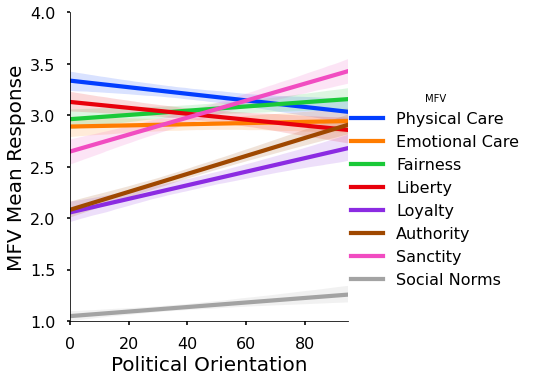

In [17]:
sns.lmplot(x='pol_orient', y='moral_decision', hue='MFV', data=vig_beh, scatter=False, hue_order=mfv_map.values(),
          palette='bright')
plt.ylim(1, 4)
sns.despine()
plt.ylabel('MFV Mean Response', fontsize=20)
plt.xlabel('Political Orientation', fontsize=20)
plt.savefig('new_plots/polx_mfv.png', dpi=200, bbox_inches='tight')
plt.show()

In [18]:
carep_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Physical Care']).fit()
carem_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Emotional Care']).fit()
fair_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Fairness']).fit()
lib_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Liberty']).fit()
loy_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Loyalty']).fit()
auth_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Authority']).fit()
sanc_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Sanctity']).fit()
socn_model = smf.ols(formula='moral_decision ~ pol_orient + age + gender', data=vig_beh[vig_beh['MFV']=='Social Norms']).fit()

In [19]:
print('Physical Care')
print(carep_model.summary2())
print('Emotional Care')
print(carem_model.summary2())
print('Fairness')
print(fair_model.summary2())
print('Liberty')
print(lib_model.summary2())
print('Loyalty')
print(loy_model.summary2())
print('Authority')
print(auth_model.summary2())
print('Sanctity')
print(sanc_model.summary2())
print('Social Norms')
print(socn_model.summary2())

Physical Care
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.032    
Dependent Variable: moral_decision   AIC:                2231.2500
Date:               2022-08-25 09:49 BIC:                2250.5038
No. Observations:   910              Log-Likelihood:     -1111.6  
Df Model:           3                F-statistic:        10.93    
Df Residuals:       906              Prob (F-statistic): 4.71e-07 
R-squared:          0.035            Scale:              0.67683  
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept       3.5176    0.3217  10.9330  0.0000   2.8862   4.1491
pol_orient     -0.0038    0.0010  -3.7303  0.0002  -0.0057  -0.0018
age            -0.0231    0.0132  -1.7445  0.0814  -0.0491   0.0029
gender          0.2122    0.0560   3.7884  0.0002   0.1023  

***